In [2]:
import pycaret
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv("/content/gdrive/My Drive/CapstoneProject/cardio_dataset.csv",delimiter=";")

### Link to Dataset
https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

In [3]:
## Loading dataset in Pandas...
df = pd.read_csv("/home/mononoke/Desktop/Gautam Project/cardio_train.csv",delimiter=";")
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,years
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,53.338686
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.765294
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,30.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,54.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,65.000000


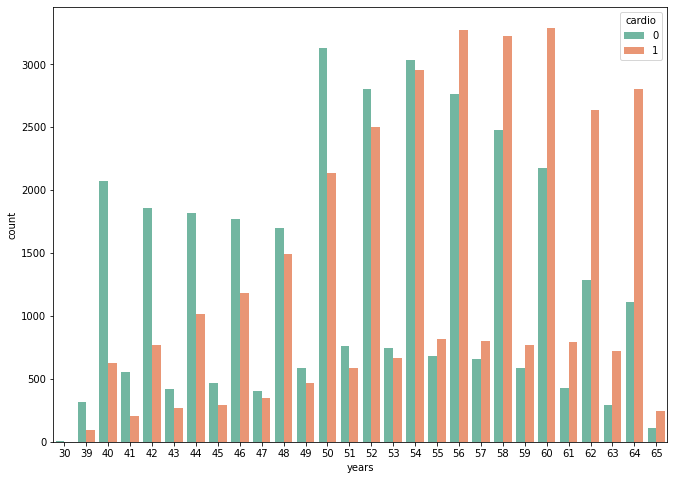

In [7]:
from matplotlib import rcParams #Sets the figure size in matplotlib
rcParams['figure.figsize'] = 11, 8
df['years'] = (df['age'] / 365).round().astype('int')
sns.countplot(x='years', hue='cardio', data = df, palette="Set2");


### Observation

#### It can be observed that people over 55 of age are more exposed to CardioVascular Diseases. From df.describe(), we can see that there are outliers in ap_hi, ap_lo, weight and height. We will deal with them later.

# Delete after Reading..
## Outliers are the values that lie very far from the data distribution .like - [1,2,3,4,5,100000,9,8,10] # So here the value 100000 is an outlier

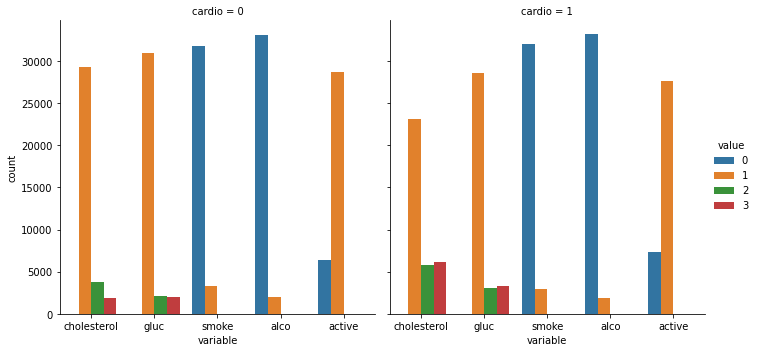

In [8]:
df_long = pd.melt(df, id_vars=['cardio'], value_vars=['cholesterol','gluc', 'smoke', 'alco', 'active'])
sns.catplot(x="variable", hue="value", col="cardio",data=df_long, kind="count")

### Observation

#### It can be clearly seen that patients with Cardio Vascular Disease have higher cholesterol and blood glucose level. And, generally speaking less active.


In [9]:
pd.crosstab(df['cardio'],df['gender'],normalize=True)

gender,1,2
cardio,,
0,0.327343,0.172957
1,0.323086,0.176614


### Observation

How the CVD is distributed among the gender ...

Gender 1 --> Women 

Gender 2 --> Men

## Preprocessing

In [10]:
df.isnull().values.any() ## Checking for null values

False

In [11]:
df["age"] = df["age"]/365 # Age was in Days so converting in Years.

In [12]:
## Adding BMI Column to the CVD disease..
df["bmi"] = df["weight"]/(df["height"]/100)**2
df = df[["age","gender","height","weight","ap_hi","ap_lo","cholesterol","gluc","smoke","alco","active","bmi","cardio"]]
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,cardio
0,50.391781,2,168,62.0,110,80,1,1,0,0,1,21.967120,0
1,55.419178,1,156,85.0,140,90,3,1,0,0,1,34.927679,1
2,51.663014,1,165,64.0,130,70,3,1,0,0,0,23.507805,1
3,48.282192,2,169,82.0,150,100,1,1,0,0,1,28.710479,1
4,47.873973,1,156,56.0,100,60,1,1,0,0,0,23.011177,0


In [13]:
## Getting rid of outliers in height and weight..
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)

In [14]:
## Getting rid of outliers in ap_hi and ap_low
## Also the blood pressure cannot be negative
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)

Diastilic pressure is higher than systolic one in 0 cases


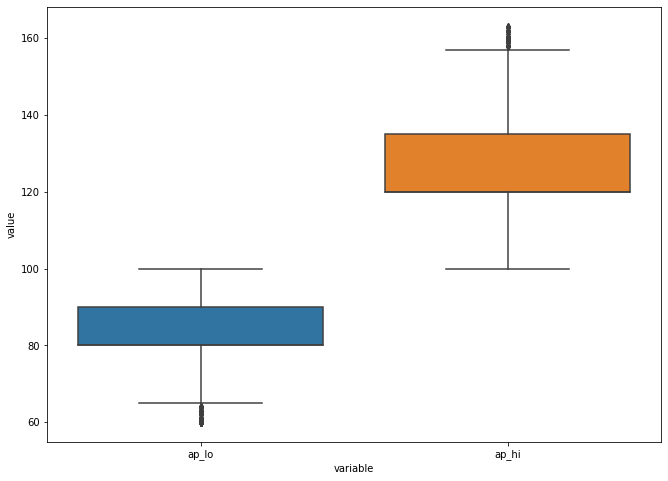

In [15]:
blood_pressure = df.loc[:,['ap_lo','ap_hi']]
sns.boxplot(x = 'variable',y = 'value',data = blood_pressure.melt()) #  For seeing the outliers in the data and if any ap_hi < ap_low..
print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

<AxesSubplot:>

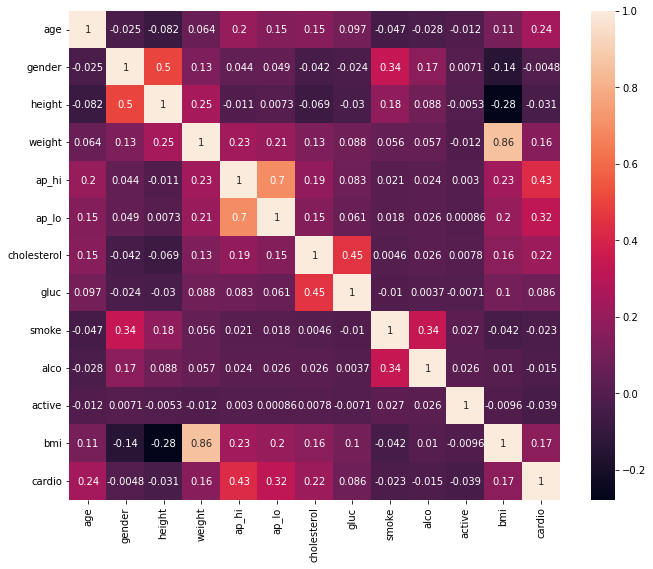

In [16]:
f, ax = plt.subplots(figsize=(11, 9))
# Heatmap gives the correlation between all the features of the dataset.
#Lighter the color more the relation between the features..
sns.heatmap(df.corr(),annot=True)

## Dataset shuffling and splitting

In [17]:
from sklearn.utils import shuffle
df = shuffle(df,random_state=42)

In [18]:
train_rows = 30000
train = df.iloc[:train_rows]
test = df.iloc[train_rows:]

X_train = train.iloc[:,:12] # 12 features 
y_train = train.iloc[:,-1] # Last column is the prediction to be done.

X_test = test.iloc[:,:12]
y_test = test.iloc[:,-1]

In [19]:
train

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,cardio
36580,48.378082,2,164,74.0,140,80,1,1,0,0,0,27.513385,1
62337,59.487671,1,160,80.0,120,80,3,1,0,0,0,31.250000,1
22383,54.128767,2,170,79.0,120,80,1,1,0,0,0,27.335640,1
59978,63.745205,1,158,74.0,120,80,1,1,0,0,0,29.642685,0
39656,56.298630,1,168,73.0,120,80,1,1,0,0,1,25.864512,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53365,50.126027,1,169,75.0,107,70,1,1,0,0,0,26.259585,1
30771,57.709589,1,163,105.0,140,90,1,1,0,0,1,39.519741,1
57997,50.380822,1,155,58.0,100,70,2,2,0,0,1,24.141519,0
6771,52.293151,1,162,70.0,130,80,1,1,0,0,1,26.672763,0


In [20]:
train.shape 

(30000, 13)

## Pycaret

In [21]:
from pycaret.classification import *
grid = setup(data=train, target=df.columns[-1], html=False, silent=True, verbose=False)

In [22]:
# One function to compare all the best performing classification models
best = compare_models() 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7233,0.7833,0.6532,0.7517,0.6989,0.4453,0.4491,0.652


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7233,0.7833,0.6532,0.7517,0.6989,0.4453,0.4491,0.652
knn,K Neighbors Classifier,0.6778,0.7247,0.6516,0.6798,0.6654,0.3550,0.3553,0.328


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7233,0.7833,0.6532,0.7517,0.6989,0.4453,0.4491,0.652
nb,Naive Bayes,0.6793,0.7467,0.5745,0.7174,0.6379,0.3564,0.3636,0.053
knn,K Neighbors Classifier,0.6778,0.7247,0.6516,0.6798,0.6654,0.3550,0.3553,0.328


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7233,0.7833,0.6532,0.7517,0.6989,0.4453,0.4491,0.652
nb,Naive Bayes,0.6793,0.7467,0.5745,0.7174,0.6379,0.3564,0.3636,0.053
knn,K Neighbors Classifier,0.6778,0.7247,0.6516,0.6798,0.6654,0.3550,0.3553,0.328
dt,Decision Tree Classifier,0.6270,0.6269,0.6207,0.6207,0.6207,0.2538,0.2538,0.092


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7233,0.7833,0.6532,0.7517,0.6989,0.4453,0.4491,0.652
nb,Naive Bayes,0.6793,0.7467,0.5745,0.7174,0.6379,0.3564,0.3636,0.053
knn,K Neighbors Classifier,0.6778,0.7247,0.6516,0.6798,0.6654,0.3550,0.3553,0.328
svm,SVM - Linear Kernel,0.6409,0.0000,0.5079,0.7641,0.5425,0.2785,0.3385,0.597
dt,Decision Tree Classifier,0.6270,0.6269,0.6207,0.6207,0.6207,0.2538,0.2538,0.092


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7244,0.0000,0.6460,0.7578,0.6974,0.4473,0.4521,0.063
lr,Logistic Regression,0.7233,0.7833,0.6532,0.7517,0.6989,0.4453,0.4491,0.652
nb,Naive Bayes,0.6793,0.7467,0.5745,0.7174,0.6379,0.3564,0.3636,0.053
knn,K Neighbors Classifier,0.6778,0.7247,0.6516,0.6798,0.6654,0.3550,0.3553,0.328
svm,SVM - Linear Kernel,0.6409,0.0000,0.5079,0.7641,0.5425,0.2785,0.3385,0.597
dt,Decision Tree Classifier,0.6270,0.6269,0.6207,0.6207,0.6207,0.2538,0.2538,0.092


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7244,0.0000,0.6460,0.7578,0.6974,0.4473,0.4521,0.063
lr,Logistic Regression,0.7233,0.7833,0.6532,0.7517,0.6989,0.4453,0.4491,0.652
rf,Random Forest Classifier,0.7047,0.7625,0.6745,0.7104,0.6919,0.4087,0.4092,0.843
nb,Naive Bayes,0.6793,0.7467,0.5745,0.7174,0.6379,0.3564,0.3636,0.053
knn,K Neighbors Classifier,0.6778,0.7247,0.6516,0.6798,0.6654,0.3550,0.3553,0.328
svm,SVM - Linear Kernel,0.6409,0.0000,0.5079,0.7641,0.5425,0.2785,0.3385,0.597
dt,Decision Tree Classifier,0.6270,0.6269,0.6207,0.6207,0.6207,0.2538,0.2538,0.092


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7244,0.0000,0.6460,0.7578,0.6974,0.4473,0.4521,0.063
lr,Logistic Regression,0.7233,0.7833,0.6532,0.7517,0.6989,0.4453,0.4491,0.652
rf,Random Forest Classifier,0.7047,0.7625,0.6745,0.7104,0.6919,0.4087,0.4092,0.843
nb,Naive Bayes,0.6793,0.7467,0.5745,0.7174,0.6379,0.3564,0.3636,0.053
knn,K Neighbors Classifier,0.6778,0.7247,0.6516,0.6798,0.6654,0.3550,0.3553,0.328
svm,SVM - Linear Kernel,0.6409,0.0000,0.5079,0.7641,0.5425,0.2785,0.3385,0.597
dt,Decision Tree Classifier,0.6270,0.6269,0.6207,0.6207,0.6207,0.2538,0.2538,0.092
qda,Quadratic Discriminant Analysis,0.5211,0.5163,0.5161,0.5627,0.4778,0.0427,0.0484,0.046


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7244,0.0000,0.6460,0.7578,0.6974,0.4473,0.4521,0.063
ada,Ada Boost Classifier,0.7240,0.7861,0.6374,0.7625,0.6943,0.4464,0.4525,0.239
lr,Logistic Regression,0.7233,0.7833,0.6532,0.7517,0.6989,0.4453,0.4491,0.652
rf,Random Forest Classifier,0.7047,0.7625,0.6745,0.7104,0.6919,0.4087,0.4092,0.843
nb,Naive Bayes,0.6793,0.7467,0.5745,0.7174,0.6379,0.3564,0.3636,0.053
knn,K Neighbors Classifier,0.6778,0.7247,0.6516,0.6798,0.6654,0.3550,0.3553,0.328
svm,SVM - Linear Kernel,0.6409,0.0000,0.5079,0.7641,0.5425,0.2785,0.3385,0.597
dt,Decision Tree Classifier,0.6270,0.6269,0.6207,0.6207,0.6207,0.2538,0.2538,0.092
qda,Quadratic Discriminant Analysis,0.5211,0.5163,0.5161,0.5627,0.4778,0.0427,0.0484,0.046


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7274,0.7922,0.6785,0.7445,0.7099,0.4538,0.4556,0.667
ridge,Ridge Classifier,0.7244,0.0000,0.6460,0.7578,0.6974,0.4473,0.4521,0.063
ada,Ada Boost Classifier,0.7240,0.7861,0.6374,0.7625,0.6943,0.4464,0.4525,0.239
lr,Logistic Regression,0.7233,0.7833,0.6532,0.7517,0.6989,0.4453,0.4491,0.652
rf,Random Forest Classifier,0.7047,0.7625,0.6745,0.7104,0.6919,0.4087,0.4092,0.843
nb,Naive Bayes,0.6793,0.7467,0.5745,0.7174,0.6379,0.3564,0.3636,0.053
knn,K Neighbors Classifier,0.6778,0.7247,0.6516,0.6798,0.6654,0.3550,0.3553,0.328
svm,SVM - Linear Kernel,0.6409,0.0000,0.5079,0.7641,0.5425,0.2785,0.3385,0.597
dt,Decision Tree Classifier,0.6270,0.6269,0.6207,0.6207,0.6207,0.2538,0.2538,0.092
qda,Quadratic Discriminant Analysis,0.5211,0.5163,0.5161,0.5627,0.4778,0.0427,0.0484,0.046


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7274,0.7922,0.6785,0.7445,0.7099,0.4538,0.4556,0.667
ridge,Ridge Classifier,0.7244,0.0000,0.6460,0.7578,0.6974,0.4473,0.4521,0.063
lda,Linear Discriminant Analysis,0.7243,0.7839,0.6459,0.7578,0.6973,0.4472,0.4520,0.055
ada,Ada Boost Classifier,0.7240,0.7861,0.6374,0.7625,0.6943,0.4464,0.4525,0.239
lr,Logistic Regression,0.7233,0.7833,0.6532,0.7517,0.6989,0.4453,0.4491,0.652
rf,Random Forest Classifier,0.7047,0.7625,0.6745,0.7104,0.6919,0.4087,0.4092,0.843
nb,Naive Bayes,0.6793,0.7467,0.5745,0.7174,0.6379,0.3564,0.3636,0.053
knn,K Neighbors Classifier,0.6778,0.7247,0.6516,0.6798,0.6654,0.3550,0.3553,0.328
svm,SVM - Linear Kernel,0.6409,0.0000,0.5079,0.7641,0.5425,0.2785,0.3385,0.597
dt,Decision Tree Classifier,0.6270,0.6269,0.6207,0.6207,0.6207,0.2538,0.2538,0.092


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7274,0.7922,0.6785,0.7445,0.7099,0.4538,0.4556,0.667
ridge,Ridge Classifier,0.7244,0.0000,0.6460,0.7578,0.6974,0.4473,0.4521,0.063
lda,Linear Discriminant Analysis,0.7243,0.7839,0.6459,0.7578,0.6973,0.4472,0.4520,0.055
ada,Ada Boost Classifier,0.7240,0.7861,0.6374,0.7625,0.6943,0.4464,0.4525,0.239
lr,Logistic Regression,0.7233,0.7833,0.6532,0.7517,0.6989,0.4453,0.4491,0.652
rf,Random Forest Classifier,0.7047,0.7625,0.6745,0.7104,0.6919,0.4087,0.4092,0.843
et,Extra Trees Classifier,0.6920,0.7444,0.6722,0.6925,0.6821,0.3836,0.3838,0.785
nb,Naive Bayes,0.6793,0.7467,0.5745,0.7174,0.6379,0.3564,0.3636,0.053
knn,K Neighbors Classifier,0.6778,0.7247,0.6516,0.6798,0.6654,0.3550,0.3553,0.328
svm,SVM - Linear Kernel,0.6409,0.0000,0.5079,0.7641,0.5425,0.2785,0.3385,0.597


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7274,0.7922,0.6785,0.7445,0.7099,0.4538,0.4556,0.667
lightgbm,Light Gradient Boosting Machine,0.7247,0.7888,0.6696,0.7450,0.7052,0.4484,0.4507,0.103
ridge,Ridge Classifier,0.7244,0.0000,0.6460,0.7578,0.6974,0.4473,0.4521,0.063
lda,Linear Discriminant Analysis,0.7243,0.7839,0.6459,0.7578,0.6973,0.4472,0.4520,0.055
ada,Ada Boost Classifier,0.7240,0.7861,0.6374,0.7625,0.6943,0.4464,0.4525,0.239
lr,Logistic Regression,0.7233,0.7833,0.6532,0.7517,0.6989,0.4453,0.4491,0.652
rf,Random Forest Classifier,0.7047,0.7625,0.6745,0.7104,0.6919,0.4087,0.4092,0.843
et,Extra Trees Classifier,0.6920,0.7444,0.6722,0.6925,0.6821,0.3836,0.3838,0.785
nb,Naive Bayes,0.6793,0.7467,0.5745,0.7174,0.6379,0.3564,0.3636,0.053
knn,K Neighbors Classifier,0.6778,0.7247,0.6516,0.6798,0.6654,0.3550,0.3553,0.328


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7274,0.7922,0.6785,0.7445,0.7099,0.4538,0.4556,0.667
lightgbm,Light Gradient Boosting Machine,0.7247,0.7888,0.6696,0.7450,0.7052,0.4484,0.4507,0.103
ridge,Ridge Classifier,0.7244,0.0000,0.6460,0.7578,0.6974,0.4473,0.4521,0.063
lda,Linear Discriminant Analysis,0.7243,0.7839,0.6459,0.7578,0.6973,0.4472,0.4520,0.055
ada,Ada Boost Classifier,0.7240,0.7861,0.6374,0.7625,0.6943,0.4464,0.4525,0.239
lr,Logistic Regression,0.7233,0.7833,0.6532,0.7517,0.6989,0.4453,0.4491,0.652
rf,Random Forest Classifier,0.7047,0.7625,0.6745,0.7104,0.6919,0.4087,0.4092,0.843
et,Extra Trees Classifier,0.6920,0.7444,0.6722,0.6925,0.6821,0.3836,0.3838,0.785
nb,Naive Bayes,0.6793,0.7467,0.5745,0.7174,0.6379,0.3564,0.3636,0.053
knn,K Neighbors Classifier,0.6778,0.7247,0.6516,0.6798,0.6654,0.3550,0.3553,0.328


### Selecting the Best Model from the Pycaret Compare Models.

In [23]:
from pycaret.classification import *
gbc = create_model("gbc",fold = 5) # Using 5 fold Cross Validation ..
tuned_gbc = tune_model(gbc) 
# Tuning the model (Pycaret selects the best hyperparameters of the model by using Random Grid Search)
# What is Random Grid Search? 
# Technique where Random Combinations of hyperParameters are used to find the best solution to the model.

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7255,0.7899,0.6785,0.7413,0.7085,0.4500,0.4516
1,0.7193,0.7824,0.6620,0.7397,0.6987,0.4374,0.4398
2,0.7298,0.7959,0.6765,0.7495,0.7111,0.4585,0.4606
3,0.7338,0.7965,0.6872,0.7504,0.7174,0.4667,0.4684
4,0.7276,0.7933,0.6852,0.7412,0.7121,0.4543,0.4556
Mean,0.7272,0.7916,0.6779,0.7444,0.7096,0.4534,0.4552
SD,0.0048,0.0051,0.0089,0.0045,0.0062,0.0097,0.0095


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7281,0.7983,0.6544,0.7596,0.7031,0.4548,0.4591
1,0.7186,0.7813,0.6621,0.7387,0.6983,0.4361,0.4384
2,0.7181,0.7806,0.6428,0.7486,0.6917,0.4348,0.4391
3,0.7262,0.7856,0.6718,0.7462,0.7071,0.4514,0.4536
4,0.7343,0.7999,0.6699,0.7613,0.7127,0.4674,0.4707
5,0.7271,0.7923,0.6696,0.7486,0.7069,0.4532,0.4556
6,0.7305,0.7928,0.6705,0.7538,0.7097,0.4598,0.4625
7,0.7381,0.7988,0.6579,0.7751,0.7117,0.4747,0.4801
8,0.7300,0.7882,0.6715,0.7524,0.7097,0.4589,0.4615
9,0.7275,0.7953,0.6570,0.7567,0.7033,0.4536,0.4575


In [35]:
evaluate_model(tuned_gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

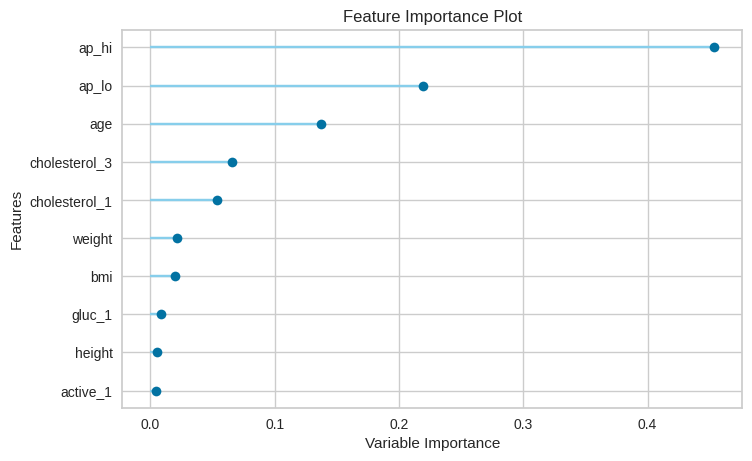

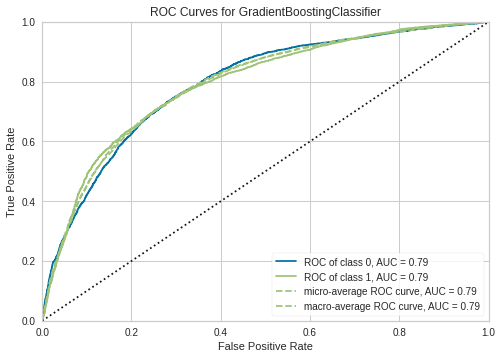

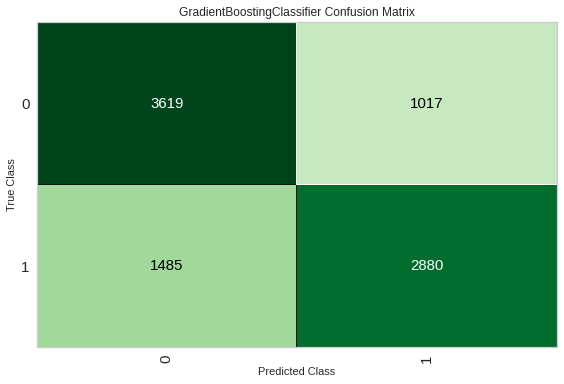

In [29]:
plot_model(tuned_gbc,plot='feature')
plot_model(tuned_gbc,plot='auc')
plot_model(tuned_gbc,plot='confusion_matrix')

In [27]:
gbc_final = finalize_model(tuned_gbc) # Finalizing the model before deploying..

In [30]:
predict_model(gbc_final,data=X_test).sort_index()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,Label,Score
2,51.663014,1,165,64.0,130,70,3,1,0,0,0,23.507805,1,0.5556
6,60.583562,1,157,93.0,130,80,3,1,0,0,1,37.729725,1,0.5791
10,61.726027,1,169,80.0,120,80,1,1,0,0,1,28.010224,0,0.5332
11,51.547945,2,173,60.0,120,80,1,1,0,0,1,20.047446,0,0.5733
13,54.271233,1,158,78.0,110,70,1,1,0,0,1,31.244993,0,0.5654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69991,56.463014,1,159,72.0,130,90,2,2,0,0,1,28.479886,1,0.5524
69993,53.969863,1,172,70.0,130,90,1,1,0,0,1,23.661439,1,0.5447
69994,57.736986,1,165,80.0,150,80,1,1,0,0,1,29.384757,1,0.5586
69995,52.712329,2,168,76.0,120,80,1,1,1,0,1,26.927438,0,0.5689


In [31]:
X_test.sort_index()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi
2,51.663014,1,165,64.0,130,70,3,1,0,0,0,23.507805
6,60.583562,1,157,93.0,130,80,3,1,0,0,1,37.729725
10,61.726027,1,169,80.0,120,80,1,1,0,0,1,28.010224
11,51.547945,2,173,60.0,120,80,1,1,0,0,1,20.047446
13,54.271233,1,158,78.0,110,70,1,1,0,0,1,31.244993
...,...,...,...,...,...,...,...,...,...,...,...,...
69991,56.463014,1,159,72.0,130,90,2,2,0,0,1,28.479886
69993,53.969863,1,172,70.0,130,90,1,1,0,0,1,23.661439
69994,57.736986,1,165,80.0,150,80,1,1,0,0,1,29.384757
69995,52.712329,2,168,76.0,120,80,1,1,1,0,1,26.927438


## Stacking Model

Why We have used Stacking?

It is an ensemble machine learning algorithm. It leverages the fact of using combining predictions of two/more base machine learning algorithms.

In [36]:
a = create_model("gbc")
b = create_model("lightgbm")
c = create_model("ridge")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7329,0.7985,0.6738,0.7565,0.7127,0.4646,0.4674
1,0.7176,0.7819,0.6796,0.7282,0.7031,0.4345,0.4354
2,0.7181,0.7777,0.6631,0.7374,0.6983,0.4351,0.4373
3,0.7205,0.7868,0.6718,0.7367,0.7028,0.4400,0.4417
4,0.7405,0.8002,0.6922,0.7590,0.7241,0.4801,0.4819
5,0.7238,0.7924,0.6822,0.7364,0.7082,0.4468,0.4479
6,0.7314,0.7957,0.6928,0.7432,0.7172,0.4621,0.4631
7,0.7381,0.8015,0.6754,0.7643,0.7171,0.4750,0.4782
8,0.7262,0.7907,0.6860,0.7383,0.7112,0.4516,0.4527
9,0.7246,0.7967,0.6686,0.7451,0.7048,0.4482,0.4505


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7262,0.7936,0.6612,0.7522,0.7038,0.4512,0.4544
1,0.7100,0.7818,0.6612,0.7251,0.6916,0.4190,0.4206
2,0.7186,0.7762,0.6592,0.7402,0.6974,0.4360,0.4386
3,0.7176,0.7826,0.6651,0.7355,0.6985,0.4342,0.4362
4,0.7248,0.7894,0.6602,0.7503,0.7024,0.4483,0.4515
5,0.7195,0.7929,0.6802,0.7305,0.7045,0.4382,0.4392
6,0.7295,0.7897,0.6802,0.7468,0.7120,0.4581,0.4598
7,0.7438,0.8025,0.6793,0.7720,0.7227,0.4864,0.4899
8,0.7314,0.7850,0.6802,0.7500,0.7134,0.4619,0.4638
9,0.7261,0.7941,0.6696,0.7470,0.7062,0.4510,0.4534


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7281,0.0,0.6457,0.7649,0.7003,0.4547,0.4602
1,0.7200,0.0,0.6399,0.7537,0.6921,0.4385,0.4435
2,0.7114,0.0,0.6225,0.7485,0.6797,0.4212,0.4271
3,0.7157,0.0,0.6457,0.7428,0.6908,0.4301,0.4337
4,0.7381,0.0,0.6583,0.7754,0.7120,0.4748,0.4801
5,0.7238,0.0,0.6453,0.7568,0.6967,0.4461,0.4509
6,0.7271,0.0,0.6676,0.7497,0.7063,0.4531,0.4558
7,0.7357,0.0,0.6453,0.7789,0.7059,0.4697,0.4766
8,0.7257,0.0,0.6550,0.7545,0.7012,0.4500,0.4539
9,0.7180,0.0,0.6347,0.7529,0.6887,0.4343,0.4396


In [37]:
stacked_models = stack_models(estimator_list=[a,b,c])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7281,0.7982,0.6680,0.7516,0.7073,0.4551,0.4578
1,0.7195,0.7841,0.6738,0.7342,0.7027,0.4382,0.4396
2,0.7224,0.7796,0.6670,0.7425,0.7027,0.4437,0.4460
3,0.7157,0.7855,0.6680,0.7309,0.6980,0.4305,0.4321
4,0.7343,0.7956,0.6815,0.7546,0.7162,0.4676,0.4698
5,0.7233,0.7940,0.6802,0.7366,0.7073,0.4458,0.4471
6,0.7338,0.7936,0.6928,0.7471,0.7190,0.4668,0.4680
7,0.7376,0.8021,0.6773,0.7623,0.7173,0.4741,0.4770
8,0.7267,0.7894,0.6841,0.7400,0.7110,0.4525,0.4537
9,0.7242,0.7975,0.6696,0.7438,0.7047,0.4473,0.4494


In [71]:
evaluate_model(stacked_models)
# plot_model(stack_models,plot='feature')
# plot_model(stack_models,plot='auc')
# plot_model(stack_models,plot='confusion_matrix')

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Classical Classification Models 

### Random Forests

In [43]:
rf = create_model("rf")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7090,0.7709,0.6718,0.7184,0.6943,0.4173,0.4182
1,0.6986,0.7572,0.6728,0.7020,0.6871,0.3966,0.3969
2,0.6990,0.7474,0.6651,0.7061,0.6849,0.3974,0.3980
3,0.7052,0.7571,0.6747,0.7112,0.6925,0.4098,0.4104
4,0.7105,0.7643,0.6805,0.7166,0.6981,0.4203,0.4209
5,0.7033,0.7627,0.6754,0.7076,0.6911,0.4060,0.4064
6,0.7110,0.7703,0.6977,0.7094,0.7035,0.4216,0.4216
7,0.7190,0.7773,0.6686,0.7356,0.7005,0.4371,0.4388
8,0.6895,0.7533,0.6676,0.6904,0.6788,0.3785,0.3787
9,0.7013,0.7642,0.6705,0.7068,0.6882,0.4019,0.4024


In [44]:
tune_rf = tune_model(rf)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7257,0.7992,0.6389,0.7648,0.6962,0.4498,0.4559
1,0.7238,0.7845,0.6447,0.7577,0.6967,0.4462,0.4511
2,0.7138,0.7732,0.6525,0.7358,0.6916,0.4264,0.4291
3,0.7200,0.7835,0.6544,0.7453,0.6969,0.4388,0.4420
4,0.7390,0.7965,0.6757,0.7662,0.7181,0.4770,0.4802
5,0.7257,0.7941,0.6657,0.7484,0.7046,0.4502,0.4529
6,0.7281,0.7908,0.6744,0.7476,0.7091,0.4551,0.4573
7,0.7352,0.7989,0.6589,0.7692,0.7098,0.4690,0.4738
8,0.7267,0.7901,0.6715,0.7468,0.7071,0.4522,0.4545
9,0.7199,0.7943,0.6444,0.7506,0.6934,0.4383,0.4426


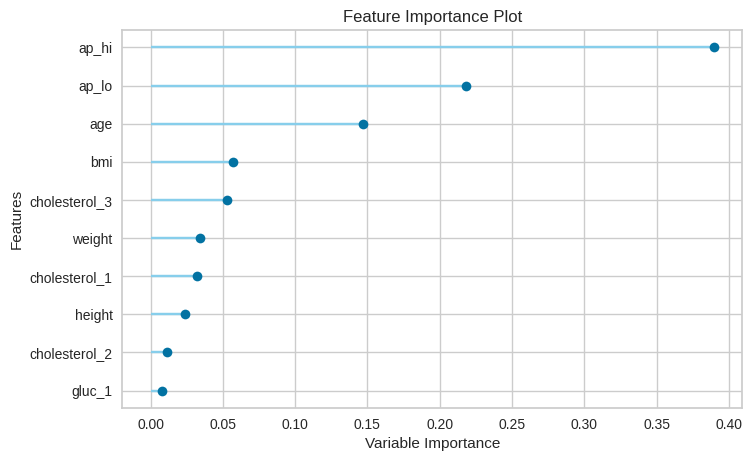

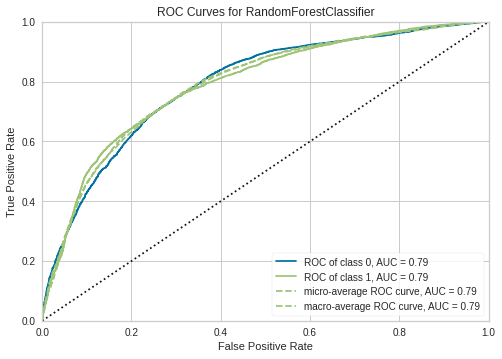

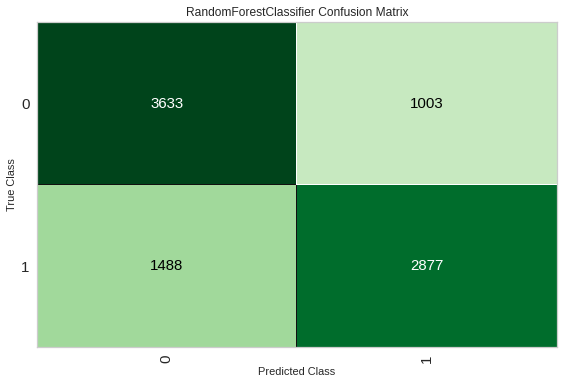

In [47]:
# evaluate_model(tune_rf)
plot_model(tune_rf,plot='feature')
plot_model(tune_rf,plot='auc')
plot_model(tune_rf,plot='confusion_matrix')

### SVM

In [48]:
svm = create_model("svm")
tune_svm = tune_model(svm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6800,0.0,0.4356,0.8349,0.5725,0.3549,0.4031
1,0.5981,0.0,0.2333,0.8225,0.3635,0.1867,0.2663
2,0.5519,0.0,0.9816,0.5238,0.6831,0.1159,0.2189
3,0.6467,0.0,0.3669,0.8116,0.5053,0.2869,0.3419
4,0.6376,0.0,0.3195,0.8505,0.4645,0.2678,0.3415
5,0.7224,0.0,0.5998,0.7845,0.6798,0.4424,0.4548
6,0.5652,0.0,0.1386,0.8563,0.2385,0.1178,0.2145
7,0.6467,0.0,0.3246,0.8816,0.4745,0.2855,0.3668
8,0.7186,0.0,0.7888,0.6858,0.7337,0.4384,0.4432
9,0.6417,0.0,0.8905,0.5899,0.7097,0.2892,0.3333


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.6s finished


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7138,0.0,0.5770,0.7842,0.6648,0.4250,0.4403
1,0.7148,0.0,0.6254,0.7529,0.6832,0.4278,0.4339
2,0.7086,0.0,0.6302,0.7389,0.6803,0.4156,0.4201
3,0.7157,0.0,0.6525,0.7390,0.6931,0.4302,0.4331
4,0.7300,0.0,0.6370,0.7741,0.6989,0.4583,0.4655
5,0.7238,0.0,0.6250,0.7697,0.6898,0.4457,0.4536
6,0.7181,0.0,0.6463,0.7461,0.6926,0.4348,0.4386
7,0.7200,0.0,0.5388,0.8323,0.6541,0.4365,0.4657
8,0.7262,0.0,0.6357,0.7673,0.6953,0.4506,0.4572
9,0.7194,0.0,0.5882,0.7873,0.6733,0.4363,0.4506


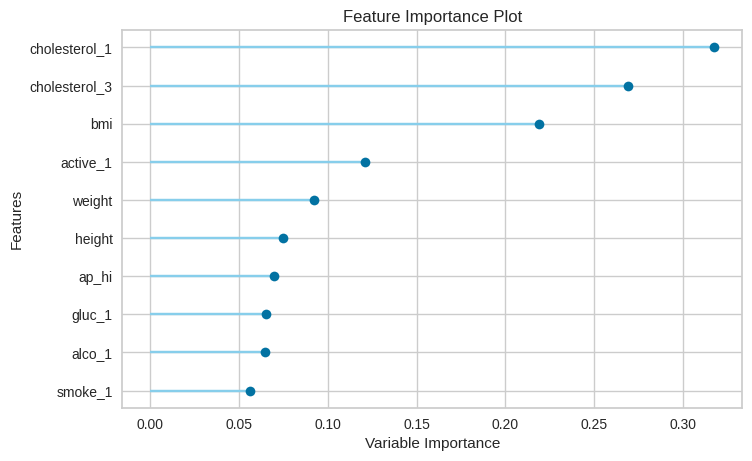

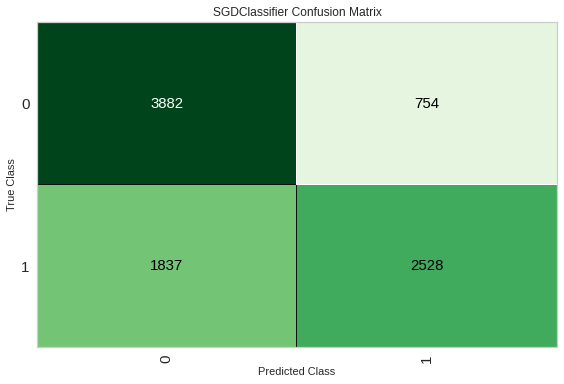

In [50]:
# evaluate_model(svm)
plot_model(tune_svm,plot='feature')
# plot_model(tune_svm,plot='auc')
plot_model(tune_svm,plot='confusion_matrix')

### Logistic Regression

In [52]:
lr = create_model("lr")
tune_lr = tune_model(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7290,0.7897,0.6573,0.7595,0.7047,0.4568,0.4609
1,0.7181,0.7754,0.6467,0.7464,0.6929,0.4348,0.4387
2,0.7124,0.7721,0.6341,0.7435,0.6844,0.4233,0.4278
3,0.7143,0.7761,0.6544,0.7356,0.6926,0.4274,0.4300
4,0.7381,0.7875,0.6612,0.7735,0.7129,0.4748,0.4798
5,0.7224,0.7899,0.6473,0.7531,0.6962,0.4433,0.4476
6,0.7252,0.7824,0.6725,0.7438,0.7064,0.4494,0.4514
7,0.7333,0.7902,0.6541,0.7688,0.7068,0.4652,0.4703
8,0.7267,0.7820,0.6657,0.7500,0.7053,0.4521,0.4549
9,0.7137,0.7877,0.6386,0.7430,0.6868,0.4259,0.4300


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.0s finished


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7290,0.7898,0.6641,0.7555,0.7069,0.4569,0.4602
1,0.7176,0.7754,0.6554,0.7407,0.6954,0.4341,0.4369
2,0.7119,0.7721,0.6418,0.7383,0.6867,0.4225,0.4260
3,0.7152,0.7761,0.6621,0.7331,0.6958,0.4294,0.4314
4,0.7357,0.7875,0.6689,0.7644,0.7135,0.4702,0.4738
5,0.7243,0.7899,0.6609,0.7486,0.7020,0.4473,0.4503
6,0.7262,0.7824,0.6802,0.7413,0.7094,0.4515,0.4530
7,0.7348,0.7902,0.6647,0.7648,0.7112,0.4682,0.4721
8,0.7257,0.7819,0.6773,0.7420,0.7082,0.4505,0.4521
9,0.7170,0.7877,0.6521,0.7412,0.6938,0.4327,0.4358


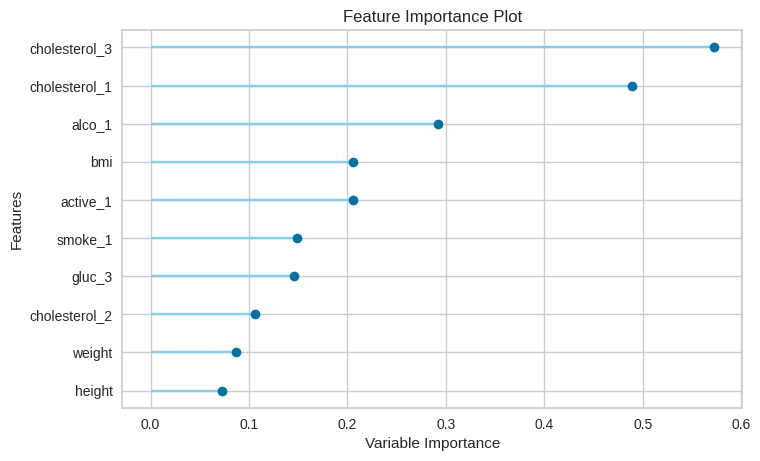

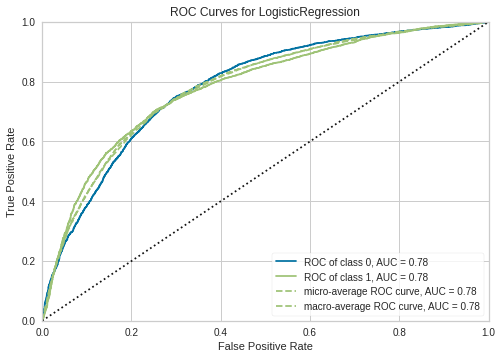

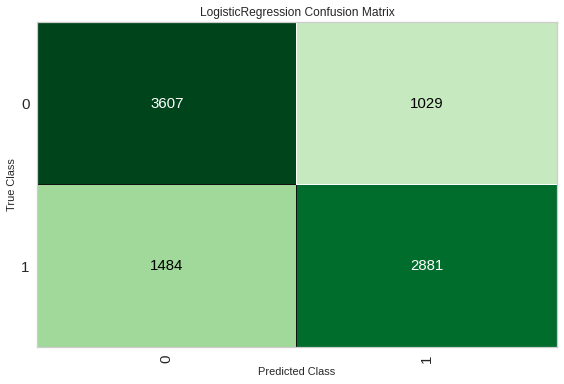

In [53]:
# evaluate_model(lr)
plot_model(tune_lr,plot='feature')
plot_model(tune_lr,plot='auc')
plot_model(tune_lr,plot='confusion_matrix')

### Naive Bayes 

In [54]:
nb = create_model("nb")
tune_nb = create_model(nb)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6890,0.7555,0.5789,0.7328,0.6468,0.3758,0.3842
1,0.6843,0.7403,0.5895,0.7182,0.6475,0.3666,0.3725
2,0.6757,0.7414,0.5673,0.7146,0.6325,0.3491,0.3566
3,0.6710,0.7382,0.5779,0.7007,0.6334,0.3399,0.3451
4,0.6805,0.7576,0.5770,0.7181,0.6398,0.3588,0.3657
5,0.6871,0.7538,0.5688,0.7347,0.6412,0.3717,0.3813
6,0.6690,0.7328,0.5911,0.6908,0.6371,0.3363,0.3397
7,0.6838,0.7522,0.5669,0.7294,0.6379,0.3650,0.3742
8,0.6819,0.7525,0.5746,0.7214,0.6397,0.3614,0.3689
9,0.6708,0.7425,0.5533,0.7129,0.6230,0.3390,0.3476


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6890,0.7555,0.5789,0.7328,0.6468,0.3758,0.3842
1,0.6843,0.7403,0.5895,0.7182,0.6475,0.3666,0.3725
2,0.6757,0.7414,0.5673,0.7146,0.6325,0.3491,0.3566
3,0.6710,0.7382,0.5779,0.7007,0.6334,0.3399,0.3451
4,0.6805,0.7576,0.5770,0.7181,0.6398,0.3588,0.3657
5,0.6871,0.7538,0.5688,0.7347,0.6412,0.3717,0.3813
6,0.6690,0.7328,0.5911,0.6908,0.6371,0.3363,0.3397
7,0.6838,0.7522,0.5669,0.7294,0.6379,0.3650,0.3742
8,0.6819,0.7525,0.5746,0.7214,0.6397,0.3614,0.3689
9,0.6708,0.7425,0.5533,0.7129,0.6230,0.3390,0.3476


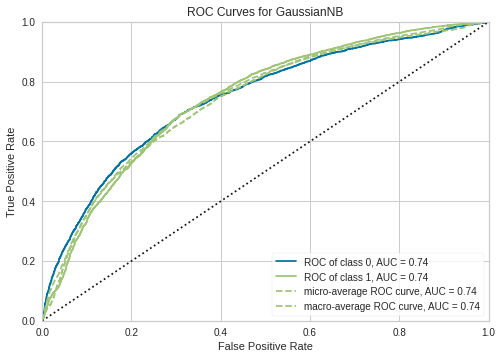

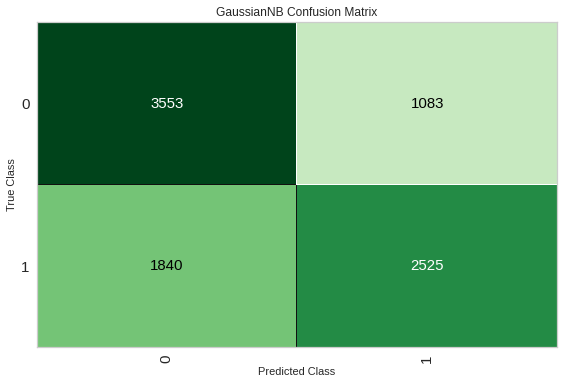

In [56]:
# evaluate_model(tuned_nb)
# plot_model(tune_nb,plot='feature')
plot_model(tune_nb,plot='auc')
plot_model(tune_nb,plot='confusion_matrix')

### K-nearest Neighbours

In [57]:
knn = create_model("knn")
tune_knn = tune_model(knn)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6771,0.7257,0.6447,0.6817,0.6627,0.3536,0.3541
1,0.6748,0.7147,0.6476,0.6771,0.6620,0.3489,0.3492
2,0.6724,0.7169,0.6554,0.6710,0.6631,0.3443,0.3444
3,0.6590,0.7029,0.6283,0.6616,0.6445,0.3174,0.3178
4,0.6790,0.7333,0.6515,0.6819,0.6663,0.3575,0.3578
5,0.6824,0.7303,0.6667,0.6805,0.6735,0.3644,0.3644
6,0.6852,0.7351,0.6686,0.6838,0.6761,0.3701,0.3701
7,0.6829,0.7365,0.6424,0.6906,0.6657,0.3648,0.3656
8,0.6838,0.7241,0.6579,0.6859,0.6716,0.3670,0.3673
9,0.6813,0.7280,0.6531,0.6843,0.6683,0.3619,0.3623


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.1s finished


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7124,0.7812,0.6215,0.7509,0.6801,0.4230,0.4293
1,0.7052,0.7682,0.6205,0.7385,0.6744,0.4088,0.4140
2,0.6948,0.7600,0.6128,0.7243,0.6639,0.3879,0.3924
3,0.7014,0.7641,0.6273,0.7281,0.6739,0.4014,0.4052
4,0.7229,0.7780,0.6389,0.7595,0.6940,0.4442,0.4497
5,0.7176,0.7851,0.6512,0.7425,0.6939,0.4339,0.4371
6,0.7205,0.7798,0.6521,0.7469,0.6963,0.4396,0.4431
7,0.7314,0.7852,0.6260,0.7840,0.6961,0.4609,0.4703
8,0.7200,0.7797,0.6453,0.7500,0.6938,0.4385,0.4427
9,0.7141,0.7804,0.6279,0.7500,0.6835,0.4266,0.4322


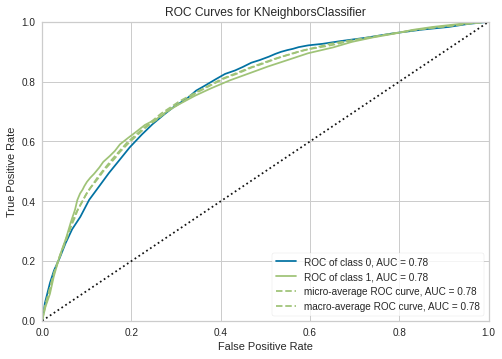

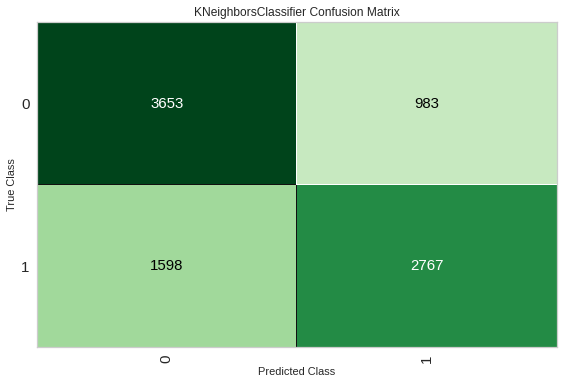

In [59]:
# evaluate_model(tuned_knn)
# plot_model(tune_knn,plot='feature')
plot_model(tune_knn,plot='auc')
plot_model(tune_knn,plot='confusion_matrix')

### Decision Trees

In [62]:
dt = create_model("dt")
tune_dt = tune_model(dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6271,0.6271,0.6263,0.6197,0.6230,0.2542,0.2542
1,0.6219,0.6218,0.6167,0.6155,0.6161,0.2436,0.2436
2,0.6124,0.6123,0.6050,0.6062,0.6056,0.2245,0.2245
3,0.6271,0.6270,0.6196,0.6214,0.6205,0.2541,0.2541
4,0.6405,0.6405,0.6399,0.6331,0.6365,0.2809,0.2809
5,0.6133,0.6130,0.5959,0.6089,0.6024,0.2262,0.2262
6,0.6338,0.6339,0.6386,0.6246,0.6315,0.2677,0.2677
7,0.6386,0.6384,0.6308,0.6327,0.6317,0.2769,0.2769
8,0.6124,0.6123,0.6056,0.6056,0.6056,0.2245,0.2245
9,0.6427,0.6425,0.6289,0.6388,0.6338,0.2850,0.2850


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7281,0.7787,0.6496,0.7625,0.7015,0.4548,0.4597
1,0.7124,0.7601,0.6438,0.7381,0.6877,0.4234,0.4268
2,0.7124,0.7610,0.6331,0.7440,0.6841,0.4232,0.4279
3,0.7167,0.7690,0.6621,0.7355,0.6969,0.4323,0.4344
4,0.7333,0.7804,0.6641,0.7631,0.7101,0.4654,0.4693
5,0.7167,0.7741,0.6483,0.7425,0.6922,0.4320,0.4354
6,0.7210,0.7730,0.6657,0.7403,0.7010,0.4408,0.4430
7,0.7310,0.7795,0.6463,0.7693,0.7025,0.4603,0.4661
8,0.7295,0.7697,0.6686,0.7533,0.7084,0.4579,0.4607
9,0.7161,0.7762,0.6415,0.7455,0.6896,0.4306,0.4348


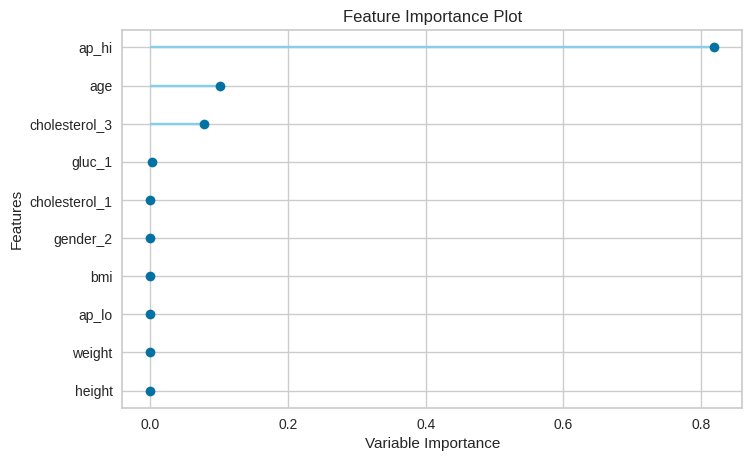

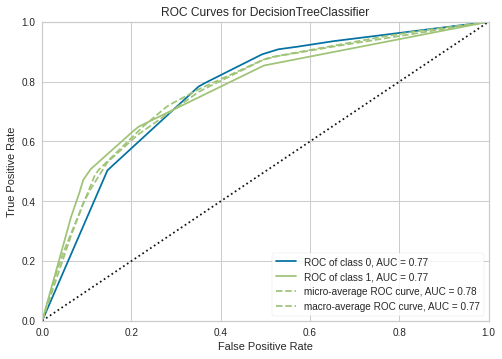

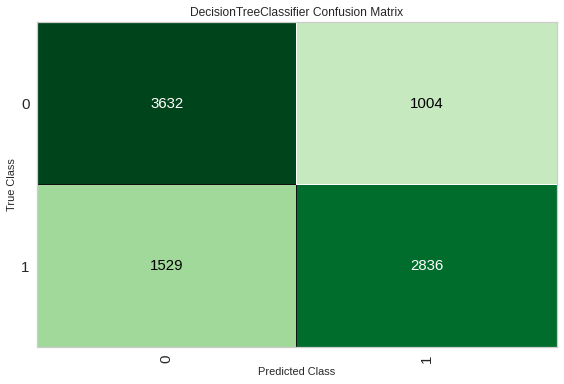

In [64]:
# evaluate_model(tuned_dt)
plot_model(tune_dt,plot='feature')
plot_model(tune_dt,plot='auc')
plot_model(tune_dt,plot='confusion_matrix')

# Evaluation And Conclusion

| Classifier  | Accuracy  | 
|---|---|
|  Stacked Method (Gradient Boosting,Light Gradient Boosting, Ridge Classification) | 72.79%  |
| Gradient Boosting | 72. 3% |
| Decision Trees | 72.15% |
|  Random Forests | 72.02%  |
| Logistic Regression | 71.07% |
| K Nearest Neighbours | 70.83% |
| Naive Bayes | 67.47% |
|  Support Vector Machines | 59.95%  |

## Why Does Stacking have the highest Accuracy ?

### The benefit of stacking is that it can harness the capabilities of a range of well-performing models on a classification or regression task and make predictions that have better performance than any single model in the ensemble.

### Gradient boosting is one of the most powerful techniques for building predictive models.

### Gradient Boosting methods are generalized methods of Ada Boost Algorithm that are very powerful algorithms for making weak learners learn more. In Ada Boost the weak learners are decision Trees.

### Gradient boosting involves three elements-
1. A loss function to be optimized.
2. A weak learner to make predictions.
3. An additive model to add weak learners to minimize the loss function.


## Possible Reason of Failure of SVM

### SVM are not meant for large datasets. They are not suitable for classifying in large datasets for one reason that the complexity of algorithm increases as the datasets become large.


## Possible Reason for Low Accuracy of Naive Bayes

### Naive Bayes is a generative algorithm meaning it tries to replicate the density of the dataset. For Naive Bayes we need independent features to work well. But in our dataset we have some features that have quite a good correlation with them.

##  Advantages of Decision Trees
1. Can work with numerical and categorical features.
2. Requires little data preprocessing: no need for one-hot encoding, dummy variables, and so on.
3. Non-parametric model: no assumptions about the shape of data.


## Random Forest is an ensemble method of many decision trees and thus would have a comparable accuracy to other machine learning classifiers.